In [1]:
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
import pickle

from scipy import optimize
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.linalg import sqrtm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes


np.set_printoptions(linewidth=np.inf)

#### parallelization 
options = qt.Options(num_cpus=6)


# Plotting setup

In [2]:

### Setup matplotlib

plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset" : "stix",
    "font.family" : "Times New Roman", 
    "text.latex.preamble": r"\usepackage[T1]{fontenc} \usepackage{lmodern} \usepackage{amsmath} \usepackage{amstext}  \usepackage{amsfonts}",
    #
    "savefig.dpi" : 300,
    "xtick.minor.visible": True, 
    "ytick.minor.visible": True,
    
    "ytick.right": True,
    "ytick.left": True,

    "xtick.top": True,
    "xtick.bottom": True,
 
    #
    "xtick.direction": "in",
    "ytick.direction": "in",
    #
    "xtick.major.width": 1.5,     # major tick width in points
    "ytick.major.width": 1.5,     # major tick width in points
    #
    "xtick.minor.width": 1.5,     # minor tick width in points
    "ytick.minor.width": 1.5,     # minor tick width in points
    #
    "xtick.major.pad": 3.0,     # distance to major tick label in points
    "ytick.major.pad": 3.0,     # distance to major tick label in points
    #
    "xtick.minor.pad": 1.5,     # distance to the minor tick label in points
    "ytick.minor.pad": 1.5,     # distance to the minor tick label in points
    #
    "xtick.major.size": 3.0, 
    "ytick.major.size": 3.0,
    
    "xtick.minor.size": 3.0, 
    "ytick.minor.size": 3.0,
    #
    "xtick.labelsize": 20, 
    "ytick.labelsize": 20,
    #
    "legend.frameon": True, 
    "legend.fontsize": 20, 
    "legend.edgecolor": "black",
    "axes.titlesize": 20, 
    "axes.titleweight": "bold",
    "axes.labelsize":20 
})

##############
####### 
### Functions for evaluating the dominant eigenvalue

# Geting eigenspectrum

In [3]:


def Get_maximum(vector):
    """
    This function returns the maximum value and the corresponding index in a given vector.
    
    Parameters:
    vector: array-like 
        Input vector to search for the maximum value. 
    
    Returns: 
    max_value: float
        Maximum value found in the input vector.
    aux_idx: int
        Index of the maximum value in the input vector.
    """
    
    # Initialize variables for index and maximum value
    aux_idx = 0
    max_value = -np.Infinity
    
    # Enumerate through the vector, checking each value
    for idx, value in enumerate(vector):
        
        # If the current maximum value is greater than the real part of the current value
        if np.real(max_value) < np.real(value): 
            
            # Update the maximum value and the corresponding index
            max_value = value
            aux_idx = idx
            
    # Return the maximum value and its index
    return max_value, aux_idx



def Numeric_diagonalization(Ws, side="left"):
    """
    This function performs the numeric diagonalization of a given matrix, 
    returning the maximum eigenvalue and the corresponding eigenvector.

    Parameters:
    Ws: array-like
        Matrix to be diagonalized. 

    Returns:
    e_values[idx]: float
        Dominant (maximum) eigenvalue of the matrix.
    e_rightvectors[idx]: array-like
        Eigenvector corresponding to the dominant eigenvalue.
    """
    # Calculate the eigenvalues and left eigenvectors of the transpose of the input matrix
    if side == "left":
        e_values, e_vectors = np.linalg.eig(np.conjugate(Ws).T)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], np.conjugate(e_mat)
    elif side == "right":
        e_values, e_vectors = np.linalg.eig(Ws)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], e_mat/np.trace(e_mat)
        
    else: raise ValueError('You have to choose or left or right')

###############
####### Coding 
###############

# Activity current observable 

In [4]:


def Trott_organize_jumps(col_times, col_which, Nboxes, args):
    # Initialize empty array
    dt = args["tau"]/(Nboxes-1)
    
    activity = [0 for _ in range(Nboxes)]

    # Organize time instants into arrays
    for i, col_list in enumerate(col_which):
        for j, col in enumerate(col_list):
            activity[i] += 1
            #entropy_current2[i] += entropy_prod_current(col_times[i][j], col, args)**2
    print(activity)
    return np.array(activity)/dt

# Jumping rates

In [5]:
########## Rates 

##### hot bath
def J_01_h_rate(t, args): 
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))) ) 
    
def J_10_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1)))) 
    
def J_02_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_20_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1))))     
    
def J_13_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1))))
    
def J_31_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_23_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))))
       
def J_32_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))))
    
##### cold bath
    
def J_01_c_rate(t, args): 
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1))) ) 

def J_10_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1)))) 
    
def J_02_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_20_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1))))     
    
def J_13_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1))))
    
def J_31_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_23_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1))))
       
def J_32_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1))))
    


# Superoperator

In [6]:
def DualSuperOperator_Lindbladian(O, t, H0, cops, args):
    """
        Code for checking if the left eigenmatrix is the actual one 
    """
    
    dO = 1.0j*( H0 * O - O * H0)
    
    for i, c in enumerate(cops):
        dO += (np.exp(-args["s_func"](t, args)) * c.dag() * O * c 
               -  0.5 * (c.dag() * c * O + O * c.dag() * c) )
    return dO 

In [7]:
#Ls = Tilted_lindbladian(args["tau"]/2, H0, [c[0]*c[1](args["tau"]/2, args) for c in c_ops_list], args)
#lambda0, l0 = Numeric_diagonalization(Ls, side="left")

#ll0 = DualSuperOperator_Lindbladian(np.conjugate(l0), args["tau"]/2, H0, [c[0]*c[1](args["tau"]/2, args) for c in c_ops_list], args)


In [8]:
def Tilted_lindbladian(t, H0, cops, args):

    """
        Evaluate the vectorize tilted Lindbladian at time $t$
    """
    
    s = args["s_func"](t, args)

    
    Ide = qt.tensor(qt.qeye(2), qt.qeye(2))

    Flat_H0  = -1.0j*(qt.tensor(Ide, H0) - qt.tensor(H0.trans(), Ide)).full()
     
    J_01_h, J_10_h, J_02_h, J_20_h, J_13_h, J_31_h, J_23_h, J_32_h = cops[0:8]
    J_01_c, J_10_c, J_02_c, J_20_c, J_13_c, J_31_c, J_23_c, J_32_c = cops[8:]
    
    ########### Flattening the operators 
    Ide = qt.tensor(qt.qeye(2), qt.qeye(2))

    ####### Non-hermitian evolution 
    ## hot bath
    
    Flat_J_01_h = -(1.0/2.0)*(qt.tensor(Ide, J_01_h.dag()*J_01_h) + qt.tensor((J_01_h.dag()*J_01_h).trans(), Ide)).full()
    Flat_J_02_h = -(1.0/2.0)*(qt.tensor(Ide, J_02_h.dag()*J_02_h) + qt.tensor((J_02_h.dag()*J_02_h).trans(), Ide)).full()
    Flat_J_13_h = -(1.0/2.0)*(qt.tensor(Ide, J_13_h.dag()*J_13_h) + qt.tensor((J_13_h.dag()*J_13_h).trans(), Ide)).full()
    Flat_J_23_h = -(1.0/2.0)*(qt.tensor(Ide, J_23_h.dag()*J_23_h) + qt.tensor((J_23_h.dag()*J_23_h).trans(), Ide)).full()

    Flat_J_10_h = -(1.0/2.0)*(qt.tensor(Ide, J_10_h.dag()*J_10_h) + qt.tensor((J_10_h.dag()*J_10_h).trans(), Ide)).full()
    Flat_J_20_h = -(1.0/2.0)*(qt.tensor(Ide, J_20_h.dag()*J_20_h) + qt.tensor((J_20_h.dag()*J_20_h).trans(), Ide)).full()
    Flat_J_31_h = -(1.0/2.0)*(qt.tensor(Ide, J_31_h.dag()*J_31_h) + qt.tensor((J_31_h.dag()*J_31_h).trans(), Ide)).full()
    Flat_J_32_h = -(1.0/2.0)*(qt.tensor(Ide, J_32_h.dag()*J_32_h) + qt.tensor((J_32_h.dag()*J_32_h).trans(), Ide)).full()

    ## cold bath
    Flat_J_01_c = -(1.0/2.0)*(qt.tensor(Ide, J_01_c.dag()*J_01_c) + qt.tensor((J_01_c.dag()*J_01_c).trans(), Ide)).full()
    Flat_J_02_c = -(1.0/2.0)*(qt.tensor(Ide, J_02_c.dag()*J_02_c) + qt.tensor((J_02_c.dag()*J_02_c).trans(), Ide)).full()
    Flat_J_13_c = -(1.0/2.0)*(qt.tensor(Ide, J_13_c.dag()*J_13_c) + qt.tensor((J_13_c.dag()*J_13_c).trans(), Ide)).full()
    Flat_J_23_c = -(1.0/2.0)*(qt.tensor(Ide, J_23_c.dag()*J_23_c) + qt.tensor((J_23_c.dag()*J_23_c).trans(), Ide)).full()

    Flat_J_10_c = -(1.0/2.0)*(qt.tensor(Ide, J_10_c.dag()*J_10_c) + qt.tensor((J_10_c.dag()*J_10_c).trans(), Ide)).full()
    Flat_J_20_c = -(1.0/2.0)*(qt.tensor(Ide, J_20_c.dag()*J_20_c) + qt.tensor((J_20_c.dag()*J_20_c).trans(), Ide)).full()
    Flat_J_31_c = -(1.0/2.0)*(qt.tensor(Ide, J_31_c.dag()*J_31_c) + qt.tensor((J_31_c.dag()*J_31_c).trans(), Ide)).full()
    Flat_J_32_c = -(1.0/2.0)*(qt.tensor(Ide, J_32_c.dag()*J_32_c) + qt.tensor((J_32_c.dag()*J_32_c).trans(), Ide)).full()

    
    Flat_Inc_h = (Flat_J_01_h + Flat_J_02_h + Flat_J_13_h + Flat_J_23_h
                + Flat_J_10_h + Flat_J_20_h + Flat_J_31_h + Flat_J_32_h)

    Flat_Inc_c = (Flat_J_01_c + Flat_J_02_c + Flat_J_13_c + Flat_J_23_c
                + Flat_J_10_c + Flat_J_20_c + Flat_J_31_c + Flat_J_32_c)

    ####### Jumps 
    # hot bath
    Flat_jump_J_01_h = (qt.tensor(J_01_h.conj(),J_01_h)).full()
    Flat_jump_J_02_h = (qt.tensor(J_02_h.conj(),J_02_h)).full()
    Flat_jump_J_13_h = (qt.tensor(J_13_h.conj(),J_13_h)).full()
    Flat_jump_J_23_h = (qt.tensor(J_23_h.conj(),J_23_h)).full()

    Flat_jump_J_10_h = (qt.tensor(J_10_h.conj(),J_10_h)).full()
    Flat_jump_J_20_h = (qt.tensor(J_20_h.conj(),J_20_h)).full()
    Flat_jump_J_31_h = (qt.tensor(J_31_h.conj(),J_31_h)).full()
    Flat_jump_J_32_h = (qt.tensor(J_32_h.conj(),J_32_h)).full()
    
    #cold bath
    Flat_jump_J_01_c = (qt.tensor(J_01_c.conj(),J_01_c)).full()
    Flat_jump_J_02_c = (qt.tensor(J_02_c.conj(),J_02_c)).full()
    Flat_jump_J_13_c = (qt.tensor(J_13_c.conj(),J_13_c)).full()
    Flat_jump_J_23_c = (qt.tensor(J_23_c.conj(),J_23_c)).full()

    Flat_jump_J_10_c = (qt.tensor(J_10_c.conj(),J_10_c)).full()
    Flat_jump_J_20_c = (qt.tensor(J_20_c.conj(),J_20_c)).full()
    Flat_jump_J_31_c = (qt.tensor(J_31_c.conj(),J_31_c)).full()
    Flat_jump_J_32_c = (qt.tensor(J_32_c.conj(),J_32_c)).full()

    Flat_Jump_h = (  np.exp(-s)*Flat_jump_J_01_h 
                   + np.exp(-s)*Flat_jump_J_02_h 
                   + np.exp(-s)*Flat_jump_J_13_h 
                   + np.exp(-s)*Flat_jump_J_23_h

                   + np.exp(-s)*Flat_jump_J_10_h 
                   + np.exp(-s)*Flat_jump_J_20_h 
                   + np.exp(-s)*Flat_jump_J_31_h 
                   + np.exp(-s)*Flat_jump_J_32_h)

    Flat_Jump_c = (  np.exp(-s)*Flat_jump_J_01_c 
                   + np.exp(-s)*Flat_jump_J_02_c 
                   + np.exp(-s)*Flat_jump_J_13_c 
                   + np.exp(-s)*Flat_jump_J_23_c

                   + np.exp(-s)*Flat_jump_J_10_c 
                   + np.exp(-s)*Flat_jump_J_20_c 
                   + np.exp(-s)*Flat_jump_J_31_c 
                   + np.exp(-s)*Flat_jump_J_32_c)

    Lst = Flat_H0 + Flat_Inc_h + Flat_Jump_h + Flat_Inc_c + Flat_Jump_c     

    return Lst.astype(complex)




# Geting the Doob auxilary system

In [9]:
def Doob_system(H0, c_ops, t, args):
    """
        Evaluate the auxiliary doob Hamiltonian 
    """
    #### Tilted Lindbladian 
    Ls = Tilted_lindbladian(t, H0, c_ops, args)
    lambda0, l0 = Numeric_diagonalization(Ls, side="left")
        
    #### Non-hermitian term of the deterministic evolution
        
    Heff = H0.copy()
    for c in c_ops:
        Heff -= 0.5j * c.dag() * c
            
    #### Calculating the Doob

    l0sqr = qt.Qobj(l0, dims=[[2, 2], [2, 2]]).sqrtm()
    Heff = l0sqr * Heff * l0sqr.inv()

    Heff = 0.5*(Heff + Heff.dag())
    Jauxlist = []
    for j, c in enumerate(c_ops):
        rotated_operator = l0sqr*c*l0sqr.inv()
        rotated_rate = np.exp(-args["s_func"](t, args)/2)
        Jauxlist.append(rotated_rate*rotated_operator)
            
    return Heff, Jauxlist

# Geting one trajectory 

In [10]:
def OneTrajectory(H0, c_ops, psi, tlist, args):
    """
        Computates one trajectory of the adiabatic evolution
        using the method of deviting the interval in $N$ subintervals, not at $dt$. 
    """
    jumps = []
    times = []

    dt = tlist[1]-tlist[0]
    for i, t in enumerate(tlist):
        print("Time interval {} + {} \n".format(t, dt))
        aux_tlist = np.linspace((i+1)*dt, (i+2)*dt, 1000)
        aux_c_ops = [j[0]*(j[1](t, args)) for j in c_ops]
        Haux, Jaux = Doob_system(H0, aux_c_ops, t, args)
        result = qt.mcsolve(Haux, psi, aux_tlist, Jaux, args=args, ntraj=1)

        jumps.append(result.col_which[0])
        times.append(result.col_times[0])

        psi = result.states[0][-1]
    return jumps, times

# Geting the SCGF 

Theory prediction

In [11]:
############# Get scaled cumulant generating function

def f(H0, cops, tlist, slist, args):
    """
        Evaluate a grid of the SCFG in (s(t), t)
    """
    grid = np.zeros((len(tlist), len(slist)))

    for i, t in enumerate(tlist):
        aux_cops = [c[0]*c[1](t, args) for c in cops]
        for j, s in enumerate(slist):
            args_copy = args.copy()
            args_copy["s_func"] = lambda t, args: s
            e_val, e_vec =  Numeric_diagonalization(Tilted_lindbladian(t, H0, aux_cops, args_copy), side="right")
            grid[i][j] = np.real(e_val)
            
    return grid.real  

############# Get activities for a trajectory

def get_activities(H0, cops, Slen, s0, sf, Tlen, args):
    """
        Evaluate a grid of the derivative of SCFG in (s(t), t)
    """
    # Compute the Legendre transform for each 

    grid = f(H0, c_ops_list, tlist=np.linspace(0, args["tau"], Tlen),
                             slist=np.linspace(s0, sf, Slen),
                             args=args)
    
    return -np.gradient(grid, np.linspace(s0, sf, Slen),  edge_order=2, axis=1)

############# Evaluating the SCGF in the path

def get_qs_path(activities, Tlen, Slen, s0, sf, args):
    """
        Get the value of the SCGF at s(t)
    """
    
    slist_aux = np.linspace(s0, sf, Slen)
    tlist_aux = np.linspace(0, args["tau"], Tlen)

    qs_values = []
    for i, t in enumerate(tlist_aux):
        qs_values.append(np.interp(args["s_func"](t, args),  slist_aux, activities[i] ))
    return qs_values

# Defining Hamiltonian and operators

In [12]:
####### Hamiltonian    

def Hamiltonian(args):
    
    H0 = (args["Omega"]*( sigmam_h*sigmap_c + sigmap_h*sigmam_c) 
        + args["g"]*(sigmax_c + sigmax_h) 
        + (args["omega"]/2)*(sigmaz_c + sigmaz_h))
    return H0
####### Initial state

In [13]:
# Define the states
ket00 = qt.tensor(qt.basis(2,1), qt.basis(2,1))
ket01 = qt.tensor(qt.basis(2,1), qt.basis(2,0))
ket10 = qt.tensor(qt.basis(2,0), qt.basis(2,1))
ket11 = qt.tensor(qt.basis(2,0), qt.basis(2,0))

sigmam_h = qt.tensor(qt.sigmam(), qt.qeye(2))
sigmam_c = qt.tensor(qt.qeye(2), qt.sigmam())
sigmap_h = qt.tensor(qt.sigmap(), qt.qeye(2))
sigmap_c = qt.tensor(qt.qeye(2), qt.sigmap())

sigmax_h = qt.tensor(qt.sigmax(), qt.qeye(2))
sigmax_c = qt.tensor(qt.qeye(2), qt.sigmax())

sigmaz_h = qt.tensor(qt.sigmaz(), qt.qeye(2))
sigmaz_c = qt.tensor(qt.qeye(2), qt.sigmaz())

eps0 = ket00
eps1 = np.sqrt(1/2)*(ket01 - ket10)
eps2 = np.sqrt(1/2)*(ket01 + ket10)
eps3 = ket11
    
##### Transitions 
    
J_01 = eps0 * eps1.dag()
    
J_10 = eps1 * eps0.dag() 
        
J_02 = eps0 * eps2.dag()
    
J_20 = eps2 * eps0.dag()
    
J_13 = eps1 * eps3.dag()

J_31 = eps3 * eps1.dag()

J_23 = eps2 * eps3.dag()
    
J_32 = eps3 * eps2.dag()


In [14]:
#####
# Putting it into a list 
    
c_ops_list = [[J_01, J_01_h_rate], 
             [J_10, J_10_h_rate],
             [J_02, J_02_h_rate],  
             [J_20, J_20_h_rate],
             [J_13, J_13_h_rate],
             [J_31, J_31_h_rate], 
             [J_23, J_23_h_rate], 
             [J_32, J_32_h_rate], 
#####################################
             [J_01, J_01_c_rate],
             [J_10, J_10_c_rate], 
             [J_02, J_02_c_rate],
             [J_20, J_20_c_rate],
             [J_13, J_13_c_rate],
             [J_31, J_31_c_rate],
             [J_23, J_23_c_rate],
             [J_32, J_32_c_rate]]


In [15]:
####### Parameters 

omega = 1.0
alpha_h = 1.0
alpha_c = 1.0
beta0_h = 1.0/(2.0) # T = 2
beta_c = 1.0/(1.0) # T = 1
Omega = 0.5
g = 1.0

def s_func_t(t, args):
    return 0.5*np.tanh(10*t/args["tau"] - 5)

def s_func_0(t, args):
    return 0*t


def beta_h(t, args):
    return args["beta0_h"]/(1 + 0.5*np.sin(t*np.pi/args["tau"])**2)
    #return np.array(t)*0 + 1/(1/args["beta0_h"])

############# Total dynamics time


tau = 2000*1000

############# Argumets dict 

args_st  = {"omega":omega,
            "Omega":Omega,
            "g":g,
            "alpha_h":alpha_h,
            "alpha_c":alpha_c,
            "beta_h":beta_h,
            "beta0_h":beta0_h,
            "beta0_c":beta_c,
            "tau":tau,
            "s_func":s_func_t}


args_s0  = {"omega":omega,
            "Omega":Omega,
            "g":g,
            "alpha_h":alpha_h,
            "alpha_c":alpha_c,
            "beta_h":beta_h,
            "beta0_h":beta0_h,
            "beta0_c":beta_c,
            "tau":tau,
            "s_func":s_func_0}

#### Parameters for predicting the s-activits'

Slen=2000
s0=-0.5
sf=0.5
Tlen=100

In [16]:


H0 = Hamiltonian(args_s0)
psi0 = ket00.copy()

####### Time window 
Nsteps = 100
tlist_traj = np.linspace(0, tau, Nsteps)

# Time-dependent: s(t)

## Trajectory

In [17]:
jumps, times =  OneTrajectory(H0, c_ops_list, psi0, tlist_traj, args_st)

Time interval 0.0 + 20202.0202020202 

Total run time:  46.06s
Time interval 20202.0202020202 + 20202.0202020202 

Total run time:  47.52s
Time interval 40404.0404040404 + 20202.0202020202 

Total run time: 662.21s
Time interval 60606.06060606061 + 20202.0202020202 

Total run time:  47.08s
Time interval 80808.0808080808 + 20202.0202020202 

Total run time:  49.07s
Time interval 101010.101010101 + 20202.0202020202 

Total run time:  46.09s
Time interval 121212.12121212122 + 20202.0202020202 

Total run time:  46.20s
Time interval 141414.1414141414 + 20202.0202020202 

Total run time:  47.37s
Time interval 161616.1616161616 + 20202.0202020202 

Total run time:  46.97s
Time interval 181818.18181818182 + 20202.0202020202 

Total run time:  47.07s
Time interval 202020.202020202 + 20202.0202020202 

Total run time:  47.83s
Time interval 222222.22222222222 + 20202.0202020202 

Total run time:  47.69s
Time interval 242424.24242424243 + 20202.0202020202 

Total run time:  47.98s
Time interval 

In [18]:
ent = Trott_organize_jumps(times, jumps, Nsteps, args_st)

[233895, 233164, 232960, 234204, 234544, 234836, 236763, 237747, 239477, 240854, 240728, 244028, 245821, 246833, 249631, 251727, 252895, 256474, 258789, 261686, 264738, 266750, 268495, 271365, 275220, 277883, 279179, 281286, 283160, 286192, 287215, 288768, 290405, 290547, 290181, 289560, 288910, 287695, 283739, 279778, 275543, 271039, 263435, 254579, 247277, 236814, 226716, 216691, 205473, 194771, 183450, 173796, 164922, 155675, 148495, 141479, 135703, 130231, 125159, 121233, 116884, 113951, 111218, 109230, 105755, 104977, 102324, 101214, 99036, 98439, 96224, 94202, 93553, 92525, 91814, 90061, 88365, 87517, 85884, 85833, 83904, 83105, 82542, 80906, 80041, 78727, 78450, 77682, 76995, 76327, 75516, 74908, 74807, 74248, 74237, 73638, 73883, 73281, 72844, 72824]


## Theory prediction

In [19]:
activities = get_activities(H0=H0, cops=c_ops_list, Slen=Slen, s0=s0, sf=sf, Tlen=Tlen, args=args_st)

In [20]:
qs_values = get_qs_path(activities, Slen=Slen, s0=s0, sf=sf, Tlen=Tlen, args=args_st)

## Plotting

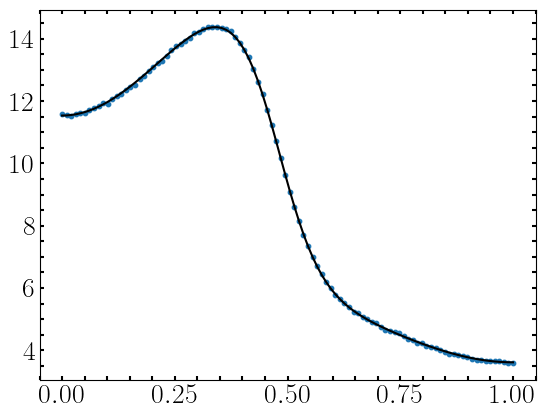

In [21]:
plt.plot(np.linspace(0, 1, Tlen), qs_values, color="black")
plt.scatter(np.linspace(0, 1, len(ent)), ent, s=10)


## Saving 

In [22]:
data_st = args_st.copy()
data_st.update({"jumps":jumps})
data_st.update({"times":times})
data_st.update({"ent":ent})
data_st.update({"SCFG_prediction":qs_values})
data_st.update({"Nboxes":np.linspace(0, 1, Nsteps)})
data_st.update({"tlist":np.linspace(0, 1, Tlen)})

del data_st["s_func"]
del data_st["beta_h"]

In [23]:
for i in data_st.keys(): print(i)

omega
Omega
g
alpha_h
alpha_c
beta0_h
beta0_c
tau
jumps
times
ent
SCFG_prediction
Nboxes
tlist


In [24]:
with open('Data_st_activity.pickle', 'wb') as handle:
    pickle.dump(data_st, handle, protocol=pickle.HIGHEST_PROTOCOL)

handle.close()

# Constant path: s = 0

## Trajectory

In [25]:
jumps_s0, times_s0 =  OneTrajectory(H0, c_ops_list, psi0, tlist_traj, args_s0)

Time interval 0.0 + 20202.0202020202 

Total run time:  27.72s
Time interval 20202.0202020202 + 20202.0202020202 

Total run time:  27.61s
Time interval 40404.0404040404 + 20202.0202020202 

Total run time:  27.43s
Time interval 60606.06060606061 + 20202.0202020202 

Total run time:  27.50s
Time interval 80808.0808080808 + 20202.0202020202 

Total run time:  27.67s
Time interval 101010.101010101 + 20202.0202020202 

Total run time:  27.96s
Time interval 121212.12121212122 + 20202.0202020202 

Total run time:  27.85s
Time interval 141414.1414141414 + 20202.0202020202 

Total run time:  28.59s
Time interval 161616.1616161616 + 20202.0202020202 

Total run time:  29.11s
Time interval 181818.18181818182 + 20202.0202020202 

Total run time:  29.13s
Time interval 202020.202020202 + 20202.0202020202 

Total run time:  28.46s
Time interval 222222.22222222222 + 20202.0202020202 

Total run time:  28.66s
Time interval 242424.24242424243 + 20202.0202020202 

Total run time:  29.00s
Time interval 

In [26]:
ent_s0 = Trott_organize_jumps(times_s0, jumps_s0, Nsteps, args_s0)

[133511, 133830, 133460, 133897, 134781, 135635, 136244, 136305, 136999, 138536, 139483, 140090, 141678, 141784, 144464, 145067, 147082, 148340, 150296, 151786, 153699, 155630, 156511, 158530, 159950, 162707, 164044, 165500, 167815, 169492, 171010, 172718, 173556, 175918, 176864, 178795, 179805, 180492, 182463, 183276, 184765, 185248, 186660, 187485, 187566, 187487, 188821, 189423, 189237, 189611, 189329, 189464, 188632, 188426, 188307, 187348, 187527, 186944, 184618, 185747, 183866, 182060, 181445, 179399, 178338, 176920, 175325, 173611, 173167, 171276, 169871, 167285, 166556, 163722, 162298, 160110, 158520, 156762, 154908, 154195, 151517, 150435, 148036, 146973, 145455, 144008, 142408, 141789, 140625, 139417, 138361, 138115, 136790, 135882, 135351, 134153, 134332, 133756, 133303, 133817]


## Theory prediction

In [27]:
#activities_s0 = get_activities(H0=H0, cops=c_ops_list,  Slen=Slen, s0=s0, sf=sf, Tlen=Tlen, args=args_s0)

In [28]:
qs_values_s0 = get_qs_path(activities, Slen=Slen, s0=s0, sf=sf, Tlen=Tlen, args=args_s0)

## Plotting

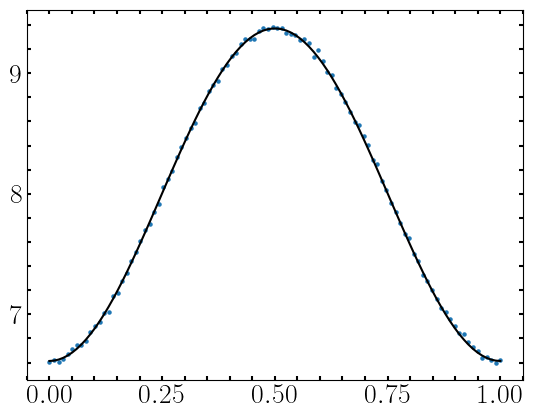

In [29]:
plt.scatter(np.linspace(0, 1, Nsteps), ent_s0, s=5)

plt.plot(np.linspace(0, 1, Tlen), qs_values_s0, color="black")

#plt.ylim((-2, 1))
#plt.xlim((0,1))

## Saving

In [30]:
data_s0 = args_s0.copy()
data_s0.update({"jumps":jumps_s0})
data_s0.update({"times":times_s0})
data_s0.update({"ent":ent_s0})
data_s0.update({"SCFG_prediction":qs_values_s0})
data_s0.update({"Nboxes":np.linspace(0, 1, Nsteps)})
data_s0.update({"tlist":np.linspace(0, 1, Tlen)})

del data_s0["s_func"]
del data_s0["beta_h"]

In [31]:
with open('Data_s0_activity.pickle', 'wb') as handle:
    pickle.dump(data_s0, handle, protocol=pickle.HIGHEST_PROTOCOL)

handle.close()

# Plotting togheter 

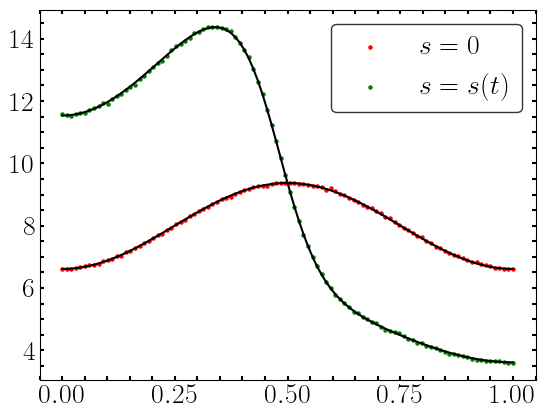

In [32]:
plt.scatter(np.linspace(0, Nsteps, Nsteps)/(Nsteps), ent_s0, s=5, color="red", label=r"$s=0$")

plt.plot(np.linspace(0, 1, Tlen), qs_values_s0, color="black")

plt.scatter(np.linspace(0, Nsteps, Nsteps)/(Nsteps), ent, s=5, color="green", label=r"$s=s(t)$")

plt.plot(np.linspace(0, 1, Tlen), qs_values, color="black")

plt.legend()
